# Part 2a: Transient behaviour and current dependency

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

try:  # if running with Google Colab
    from google.colab import drive
    drive.mount('/content/drive')

    import sys
    # the location where you saved the tools.py and csv files
    drive_dir = '/content/drive/My Drive/Colab Notebooks/FCTT 3'
    sys.path.insert(0, drive_dir)

    data_dir =os.path.join(drive_dir, 'battery_experimental_data')
except:  # if running locally
    data_dir = os.path.abspath('battery_experimental_data')
    
from tools import *

## Load data

In [3]:
training_data_20 = pd.read_csv(os.path.join(data_dir, 'Model_Training_Data_20.csv'))
SOC_OCV_data = pd.read_csv(os.path.join(data_dir, 'SOC_OCV_MFCTT_2019.csv'), sep='\t')

display(training_data_20.head())

,Time (s),Current (A),Voltage (V)
0,0.000000,0.0,4.2
1,1.000005,0.0,4.2
2,1.999999,0.0,4.2
3,3.000004,0.0,4.2
4,3.999998,0.0,4.2


In [29]:
# extract values in numpy array
ref_SOC = SOC_OCV_data['SOC'].values                   # unit in %
ref_OCV = SOC_OCV_data['Ecell/V'].values               # unit in V

t = training_data_20['Time (s)'].values                # unit in s
I = training_data_20['Current (A)'].values             # unit in A
V_actual = training_data_20['Voltage (V)'].values      # unit in V

SOC_levels = np.arange(0.9, 0.1, -0.1)
SOC_from_idx_map = {i: SOC_levels[i] for i in range(8)}  # 8 SOC levels

## Splitting pulses

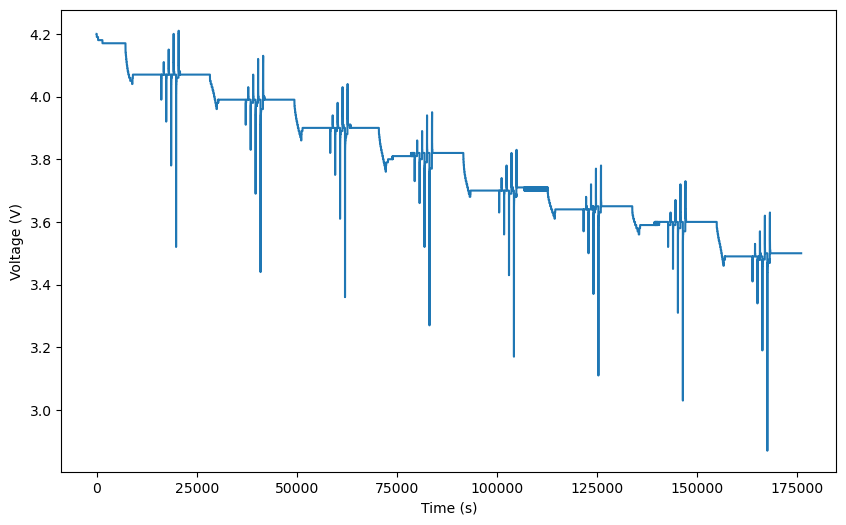

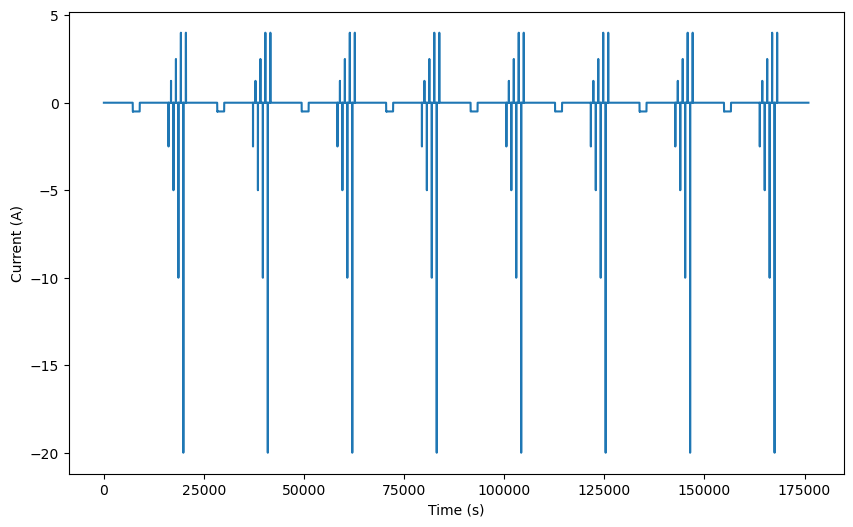

In [5]:
_, ax = plt.subplots(figsize=(10, 6))
ax.plot(t, V_actual)
# ax.set_xlim([0, t[-1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (V)')

_, ax = plt.subplots(figsize=(10, 6))
ax.plot(t, I)
# ax.set_xlim([0, t[-1]])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Current (A)')

plt.show()

In [6]:
# shift to left by one index (now i is equivalent to i+1)
I_shifted = np.concatenate((I[1:], [0]))
idx_pulse_start = np.flatnonzero((I == 0) & (np.abs(I_shifted) > 1))
idx_pulse_end = np.flatnonzero((np.abs(I) > 1) & (I_shifted == 0)) + 1

# reshape to 8 x 8 matrix, where rows correspond to each SOC value and
#                                cols correspond to each pulse with different current
idx_pulse_start = idx_pulse_start.reshape(8, 8)
idx_pulse_end = idx_pulse_end.reshape(8, 8)
# print(idx_pulse_start)
# print(idx_pulse_end)

to get the starting positions for all SOC values:

idx_pulse_start[:, 0]

## A bit visulisation (not part of the answer):

For each SOC value, we will have:

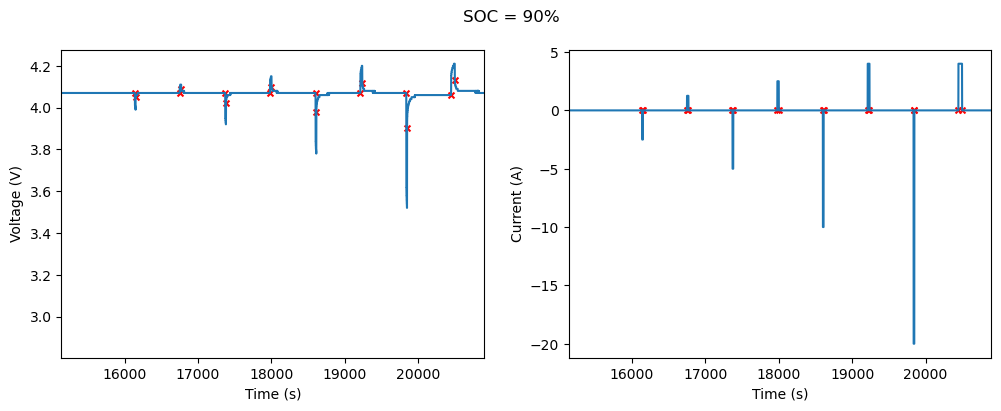

In [36]:
show_SOC = 1  # which_SOC_to_inspect, 1 represent the first cluster
SOC_level = SOC_from_idx_map[show_SOC-1]

xlim = [t[idx_pulse_start[show_SOC-1, 0] - 1000], 
        t[idx_pulse_end[show_SOC-1, -1] + 4000]]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(t, V_actual)
axes[0].scatter(t[idx_pulse_start], V_actual[idx_pulse_start], c='r',s=18, marker='x')
axes[0].scatter(t[idx_pulse_end], V_actual[idx_pulse_end], c='r',s=18, marker='x')
axes[0].set_xlim(xlim)
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Voltage (V)')

axes[1].plot(t, I)
axes[1].scatter(t[idx_pulse_start], I[idx_pulse_start], c='r',s=18, marker='x')
axes[1].scatter(t[idx_pulse_end], I[idx_pulse_end], c='r',s=18, marker='x')
axes[1].set_xlim(xlim)
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Current (A)')

fig.suptitle('SOC = {:0.0f}%'.format(SOC_level*100))
plt.show()

Further zoom in:

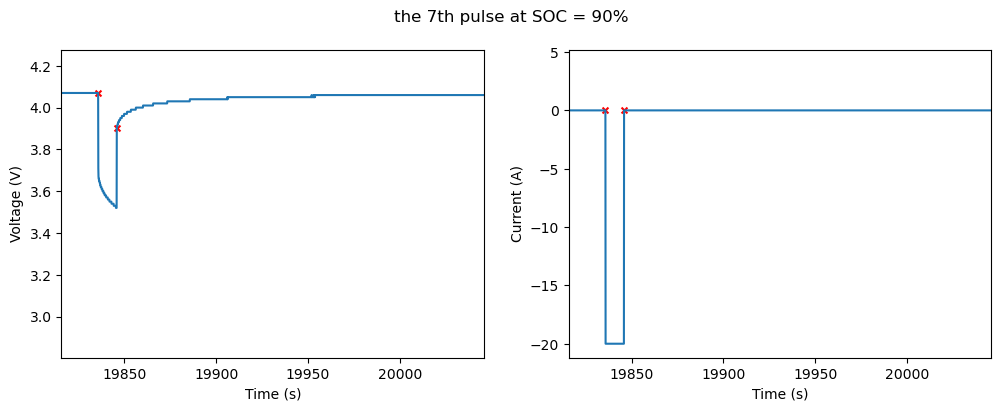

In [42]:
show_SOC = 1  # which_SOC_to_inspect
show_pulse = 7  # which_pulse_to_inspect
SOC_level = SOC_from_idx_map[show_SOC-1]

xlim = [t[idx_pulse_start[show_SOC-1, show_pulse-1] - 200],
        t[idx_pulse_end[show_SOC-1, show_pulse-1] + 2000]]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(t, V_actual)
axes[0].scatter(t[idx_pulse_start], V_actual[idx_pulse_start], c='r',s=18, marker='x')
axes[0].scatter(t[idx_pulse_end], V_actual[idx_pulse_end], c='r',s=18, marker='x')
axes[0].set_xlim(xlim)
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Voltage (V)')

axes[1].plot(t, I)
axes[1].scatter(t[idx_pulse_start], I[idx_pulse_start], c='r',s=18, marker='x')
axes[1].scatter(t[idx_pulse_end], I[idx_pulse_end], c='r',s=18, marker='x')
axes[1].set_xlim(xlim)
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Current (A)')

fig.suptitle('the {}th pulse at SOC = {:0.0f}%'.format(show_pulse,
                                                       SOC_level*100))
plt.show()

idx_pulse_start and idx_pulse_end identify the position where the current pulse start and finish. For the voltage, it needs some times to rest and recover to zero.

Therefore, to split the overall graph for different pulses, only idx_pulse_start is used. idx_pulse_end can be used to do parametrisation (see later).


### Find index of steady-state voltage for each pulse

In [52]:
idx_Vss = []
all_ends = idx_pulse_end.flatten()
for pos in range(len(all_ends)):
    i = 0
    while True:
        # if observing num_criteria of constant values, steady state is reached
        num_criteria = 500
        segment = V_actual[all_ends[pos]+i : all_ends[pos]+i+num_criteria] 
        if np.all(segment == segment[0]):  # all element in this array are the same
            idx_Vss.append(all_ends[pos]+i)
            break
        i += 1
        
        # Stop browsing if touching the next next pulse
        i_limit = np.concatenate((idx_pulse_start.flatten()[1:], [len(t)]))
        if i > i_limit[pos]:
            which_SOC = pos//8
            SOC_level = SOC_from_idx_map[which_SOC]
            msg = "Position of V_ss is not found for the {}th pulse at SOC = {:0.0f}%".format(pos%8, SOC_level*100)
            raise ValueError(msg)
        
idx_Vss = np.reshape(idx_Vss, [8, 8])

Plot the steady-state voltage of each pulse:

In [106]:
def plot_Vss(t, V, idx_pulse_start, idx_pulse_end, idx_Vss, 
             SOC, pulse):
    SOC_level = SOC_from_idx_map[SOC-1]
    if pulse == 'all':
        xlim = [t[idx_pulse_start[SOC-1, 0] - 300], 
                t[idx_Vss[SOC-1, -1] + 4000]]
        ylim = [np.min(V[idx_pulse_start[SOC-1, 0]:idx_Vss[SOC-1, -1]])-0.05, 
                np.max(V[idx_pulse_start[SOC-1, 0]:idx_Vss[SOC-1, -1]])+0.05]
        title = 'SOC = {:0.0f}%'.format(SOC_level*100)
    else:
        xlim = [t[idx_pulse_start[SOC-1, pulse-1] - 200],
                t[idx_Vss[SOC-1, pulse-1] + 2000]]
        ylim = [np.min(V[idx_pulse_start[SOC-1, pulse-1]:idx_Vss[SOC-1, pulse-1]])-0.05, 
                np.max(V[idx_pulse_start[SOC-1, pulse-1]:idx_Vss[SOC-1, pulse-1]])+0.05]
        title = 'the {}th pulse at SOC = {:0.0f}%'.format(pulse,
                                                          SOC_level*100)

    _, ax = plt.subplots(figsize=(10, 4))
    ax.plot(t, V)
    ax.scatter(t[idx_pulse_start], V_actual[idx_pulse_start], 
               c='r',s=20, marker='x', label='Pulse start/end')
    ax.scatter(t[idx_pulse_end], V_actual[idx_pulse_end],
               c='r',s=20, marker='x')
    ax.scatter(t[idx_Vss], V_actual[idx_Vss],
               c='g',s=20, marker='x', label='Steady State Voltage')
    
    ax.legend()
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Voltage (V)')

    ax.set_title(title)
    plt.show()

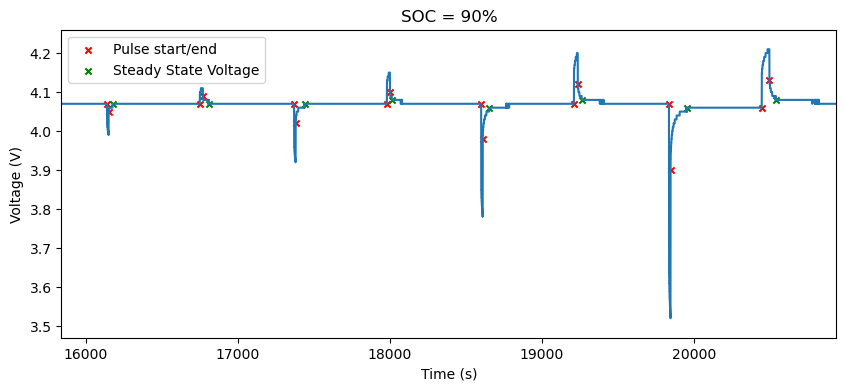

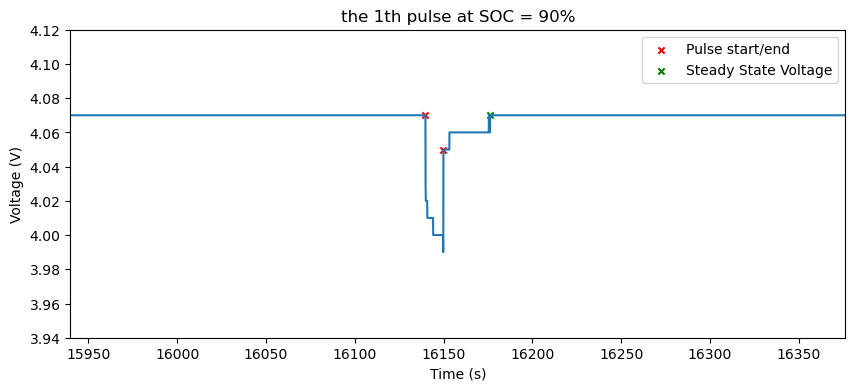

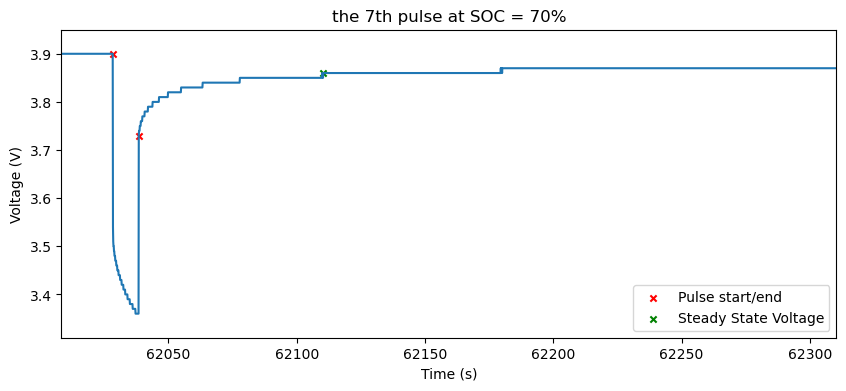

In [107]:
which_SOC_to_show = 1
which_pulse_to_show = 'all'
plot_Vss(t, V_actual, idx_pulse_start, idx_pulse_end, idx_Vss, 
         which_SOC_to_show, which_pulse_to_show)

which_SOC_to_show = 1
which_pulse_to_show = 1
plot_Vss(t, V_actual, idx_pulse_start, idx_pulse_end, idx_Vss, 
         which_SOC_to_show, which_pulse_to_show)

which_SOC_to_show = 3
which_pulse_to_show = 7
plot_Vss(t, V_actual, idx_pulse_start, idx_pulse_end, idx_Vss, 
         which_SOC_to_show, which_pulse_to_show)

## Parametrisation

In [77]:
V_peaks = V_actual[idx_pulse_end - 1]
I_peaks = I[idx_pulse_end - 1]

d_V0 = V_actual[idx_pulse_end] - V_peaks
d_I = I[idx_pulse_end] - I_peaks
R0_tab = d_V0 / d_I  # look-up table

d_Vinf = V_actual[idx_Vss] - V_peaks
R1_tab = d_Vinf / d_I - R0_tab

C1_tab = (t[idx_Vss] - t[idx_pulse_end]) / (4*R1_tab)

# Visualisation:
rows = pd.MultiIndex.from_product([['%d%%' % (SOC_from_idx_map[i]*100) for i in range(8)],
                                   np.arange(1, 9)],
                                   names=['SOC', 'Pulse'])

df = pd.DataFrame({'$R_0$ $(\Omega)$': R0_tab.flatten(),
                   '$R_1$ $(\Omega)$': R1_tab.flatten(),
                   '$C_1$ $(F)$': C1_tab.flatten()}, index=rows)

# For display:
df1, df2 = np.array_split(df, 2, axis=0)
table1 = df1.to_html()
table2 = df2.to_html()

# Concatenate the HTML tables horizontally
html = '<table><tr><td>{0}</td><td>{1}</td></tr></table>'.format(table1, table2)

display(HTML(html))

### Step c

$R_0$ is nearly constant, thus remove the dependency

In [13]:
R0_const = np.mean(R0_tab)
R0_const

0.019554687500000018

### Step d

Do the same for $C_1$ as instructed, but why?

In [14]:
C1_const = np.mean(C1_tab)
C1_const

1122.1114288965327

### Step e

Refit R1 using the constant R0 (and C1?)

In [225]:
R1_tab = d_Vinf / d_I - R0_const
print(np.round(R1_tab, 5))

[[0.01245 0.01245 0.01045 0.00845 0.00845 0.01045 0.00745 0.01295]
 [0.00845 0.01245 0.01045 0.00845 0.00845 0.01045 0.00595 0.01295]
 [0.00845 0.01245 0.00845 0.00845 0.00745 0.01045 0.00545 0.01295]
 [0.00845 0.01245 0.00845 0.00845 0.00645 0.01045 0.00545 0.01295]
 [0.00845 0.01245 0.00645 0.00845 0.00645 0.00795 0.00595 0.01045]
 [0.00845 0.00445 0.00845 0.00845 0.00645 0.01045 0.00595 0.01045]
 [0.00845 0.00445 0.00845 0.00845 0.00745 0.01045 0.00745 0.01045]
 [0.01245 0.01245 0.00845 0.00845 0.00945 0.01045 0.01045 0.01045]]


Let's see its dependency on SOC:

In [226]:
SOV_at_Vss = [round(match_val(vss, ref_OCV, ref_SOC), 1) for vss in V_actual[idx_Vss].flatten()]
print('SOC after at each V_ss:\n')
print(np.reshape(SOV_at_Vss, [8, 8]))

SOC after at each V_ss:

[[89.6 89.6 89.6 92.4 87.2 92.4 87.2 92.4]
 [79.9 80.7 79.9 81.5 79.  81.5 77.2 81.5]
 [70.3 71.7 70.3 73.  69.1 73.  66.8 73. ]
 [61.2 62.9 61.2 62.9 59.7 62.9 58.9 62.9]
 [51.7 51.7 50.4 52.9 50.4 52.9 49.  52.9]
 [42.3 44.2 42.3 44.2 40.3 44.2 38.2 44.2]
 [32.7 34.4 32.7 34.4 31.3 34.4 30.1 36.2]
 [22.7 22.7 22.  23.4 22.  23.4 20.7 24.2]]


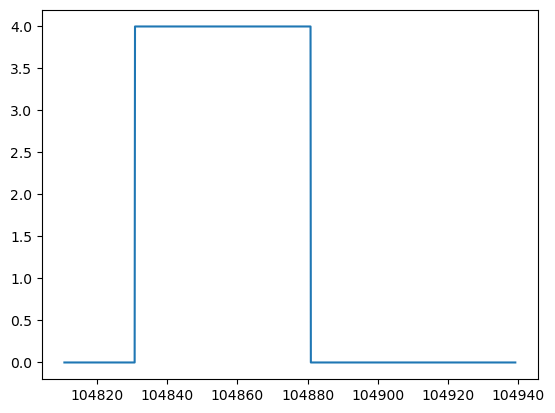

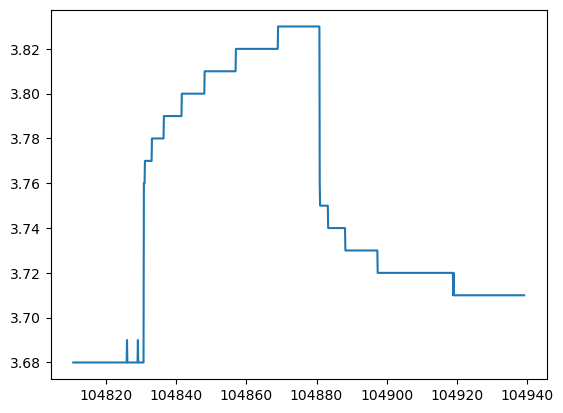

In [122]:
pad_zero = True
which_SOC = 1
which_pulse = 1

if pad_zero:
    idx_seg_start = idx_pulse_start[which_SOC-1, which_pulse-1] - 200
    idx_seg_end = idx_Vss[which_SOC-1, which_pulse-1] + 200
else:
    idx_seg_start = idx_pulse_start[which_SOC-1, which_pulse-1]
    idx_seg_end = idx_Vss[which_SOC-1, which_pulse-1]

t_seg = t[idx_seg_start : idx_seg_end+1]
V_actual_seg = V_actual[idx_seg_start : idx_seg_end+1]
I_seg = I[idx_seg_start : idx_seg_end+1]

plt.plot(t_seg, I_seg)
plt.show()
plt.plot(t_seg, V_actual_seg)
plt.show()

In [123]:
t_seg = t[idx_seg_start : idx_seg_end+1]
V_actual_seg = V_actual[idx_seg_start : idx_seg_end+1]
I_seg = I[idx_seg_start : idx_seg_end+1]

Now we have R0, R1, C1 as functions of SOC and current, but we only have limited points. For example, if we need R1 at 84 % SOC, we need to linear-interpolate it.

In [ ]:
z0 = match_val(V_actual_seg[0], ref_OCV, ref_SOC)
Q = 2500
eta = 1

N = len(t)
z = np.ndarray(N)
V_pred = np.ndarray(N)
OCV = np.ndarray(N)
I_R1 = np.ndarray(N)

z[0] = z0
I_R1 = 0
def update_I_R1(i, I_R1, t, I, R1, C1):
    dt = t[i+1] - t[i]
    a = -1 / (R1*C1)
    b = 1 / (R1*C1)
    I_R1[i+1] = np.exp(a*dt) * I_R1[i] + \
                1/a * (np.exp(a*dt)-1) * b * I[i]
    
for i in range(N):
    if i != N-1:
        update_SOC(i, z, t, I, eta, Q)
        
        update_I_R1(i, I_R1, t, I, R1, C1)

In [195]:
R1_tab  # SOC and current dependent

array([[0.01244531, 0.01244531, 0.01044531, 0.00844531, 0.00844531,
        0.01044531, 0.00744531, 0.01294531],
       [0.00844531, 0.01244531, 0.01044531, 0.00844531, 0.00844531,
        0.01044531, 0.00594531, 0.01294531],
       [0.00844531, 0.01244531, 0.00844531, 0.00844531, 0.00744531,
        0.01044531, 0.00544531, 0.01294531],
       [0.00844531, 0.01244531, 0.00844531, 0.00844531, 0.00644531,
        0.01044531, 0.00544531, 0.01294531],
       [0.00844531, 0.01244531, 0.00644531, 0.00844531, 0.00644531,
        0.00794531, 0.00594531, 0.01044531],
       [0.00844531, 0.00444531, 0.00844531, 0.00844531, 0.00644531,
        0.01044531, 0.00594531, 0.01044531],
       [0.00844531, 0.00444531, 0.00844531, 0.00844531, 0.00744531,
        0.01044531, 0.00744531, 0.01044531],
       [0.01244531, 0.01244531, 0.00844531, 0.00844531, 0.00944531,
        0.01044531, 0.01044531, 0.01044531]])

In [196]:
# get the pulse current, useful for later interpolation (8 x 1)
I_pulse = I[idx_pulse_start+1][0]


In [197]:
I_peaks[0]

array([ -2.5 ,   1.25,  -5.  ,   2.5 , -10.  ,   4.  , -20.  ,   4.  ])

In [169]:
from scipy.interpolate import interp2d
interp_func = interp2d(I_tab, SOC_tab, temp2)

target_I = 
target_SOC = 0.5
interp_func(target_I, target_SOC)

array([0.])

In [200]:
from scipy.interpolate import interp2d

# I_tab[-1] = 6
interp_func = interp2d(I_tab, SOC_tab, temp2)

target_I = -6
target_SOC = 0.3

interp_value = interp_func(target_I, target_SOC)

print('Interpolated value:', interp_value)

Interpolated value: [nan]


In [201]:
SOC_tab

array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [202]:
I_tab

array([-20.  , -10.  ,  -5.  ,  -2.5 ,   1.25,   2.5 ,   4.  ,   4.  ])

In [213]:
sorted_idx_col

array([6, 4, 2, 0, 1, 3, 5, 7], dtype=int64)

In [212]:
R1_tab

array([[0.01244531, 0.01244531, 0.01044531, 0.00844531, 0.00844531,
        0.01044531, 0.00744531, 0.01294531],
       [0.00844531, 0.01244531, 0.01044531, 0.00844531, 0.00844531,
        0.01044531, 0.00594531, 0.01294531],
       [0.00844531, 0.01244531, 0.00844531, 0.00844531, 0.00744531,
        0.01044531, 0.00544531, 0.01294531],
       [0.00844531, 0.01244531, 0.00844531, 0.00844531, 0.00644531,
        0.01044531, 0.00544531, 0.01294531],
       [0.00844531, 0.01244531, 0.00644531, 0.00844531, 0.00644531,
        0.00794531, 0.00594531, 0.01044531],
       [0.00844531, 0.00444531, 0.00844531, 0.00844531, 0.00644531,
        0.01044531, 0.00594531, 0.01044531],
       [0.00844531, 0.00444531, 0.00844531, 0.00844531, 0.00744531,
        0.01044531, 0.00744531, 0.01044531],
       [0.01244531, 0.01244531, 0.00844531, 0.00844531, 0.00944531,
        0.01044531, 0.01044531, 0.01044531]])

In [211]:
temp2

array([[0.01044531, 0.00944531, 0.00844531, 0.01244531, 0.01244531,
        0.00844531, 0.01044531, 0.01044531],
       [0.00744531, 0.00744531, 0.00844531, 0.00844531, 0.00444531,
        0.00844531, 0.01044531, 0.01044531],
       [0.00594531, 0.00644531, 0.00844531, 0.00844531, 0.00444531,
        0.00844531, 0.01044531, 0.01044531],
       [0.00594531, 0.00644531, 0.00644531, 0.00844531, 0.01244531,
        0.00844531, 0.00794531, 0.01044531],
       [0.00544531, 0.00644531, 0.00844531, 0.00844531, 0.01244531,
        0.00844531, 0.01044531, 0.01294531],
       [0.00544531, 0.00744531, 0.00844531, 0.00844531, 0.01244531,
        0.00844531, 0.01044531, 0.01294531],
       [0.00594531, 0.00844531, 0.01044531, 0.00844531, 0.01244531,
        0.00844531, 0.01044531, 0.01294531],
       [0.00744531, 0.00844531, 0.01044531, 0.01244531, 0.01244531,
        0.00844531, 0.01044531, 0.01294531]])

In [210]:
# sorted(I_pulse)
sorted_idx_col = np.argsort(I_peaks[0])
temp = R1_tab[:, sorted_idx_col]
I_tab = I_peaks[0, sorted_idx_col]

sorted_idx_row = np.argsort(SOC_levels)
temp2 = temp[sorted_idx_row, :]
SOC_tab = SOC_levels[sorted_idx_row]
# I_tab = sorted(I_peaks[0])
# SOC_tab = sorted(SOC_levels)

In [214]:
V_actual[idx_Vss]

array([[4.07, 4.07, 4.07, 4.08, 4.06, 4.08, 4.06, 4.08],
       [3.98, 3.99, 3.98, 4.  , 3.97, 4.  , 3.95, 4.  ],
       [3.89, 3.9 , 3.89, 3.91, 3.88, 3.91, 3.86, 3.91],
       [3.8 , 3.82, 3.8 , 3.82, 3.78, 3.82, 3.77, 3.82],
       [3.7 , 3.7 , 3.69, 3.71, 3.69, 3.71, 3.68, 3.71],
       [3.64, 3.65, 3.64, 3.65, 3.63, 3.65, 3.62, 3.65],
       [3.59, 3.6 , 3.59, 3.6 , 3.58, 3.6 , 3.57, 3.61],
       [3.49, 3.49, 3.48, 3.5 , 3.48, 3.5 , 3.47, 3.51]])

In [218]:
# map(match_val, V_actual[idx_Vss])
SOV_at_Vss = [round(match_val(vss, ref_OCV, ref_SOC), 1) for vss in V_actual[idx_Vss].flatten()]
print(np.reshape(SOV_at_Vss, [8, 8]))
# result = list(map(lambda vss: match_val(vss, ref_OCV, ref_SOC), V_actual[idx_Vss]))

[[89.6 89.6 89.6 92.4 87.2 92.4 87.2 92.4]
 [79.9 80.7 79.9 81.5 79.  81.5 77.2 81.5]
 [70.3 71.7 70.3 73.  69.1 73.  66.8 73. ]
 [61.2 62.9 61.2 62.9 59.7 62.9 58.9 62.9]
 [51.7 51.7 50.4 52.9 50.4 52.9 49.  52.9]
 [42.3 44.2 42.3 44.2 40.3 44.2 38.2 44.2]
 [32.7 34.4 32.7 34.4 31.3 34.4 30.1 36.2]
 [22.7 22.7 22.  23.4 22.  23.4 20.7 24.2]]
